In [1]:
!pip install split-folders


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import os
import splitfolders
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [3]:
DATA_DIR = 'asl_dataset'
OUTPUT_DIR = 'asl_split_dataset' 

# splitfolders.ratio(DATA_DIR, output=OUTPUT_DIR, seed=42, ratio=(0.64, 0.16, 0.2))

In [4]:
IMAGE_SIZE = (224, 224, 3)  
BATCH_SIZE = 32
EPOCHS = 1000
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.2

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

In [5]:
num_classes = 36

In [6]:
rescale_layer = tf.keras.layers.Rescaling(1./255)

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

Found 1581 files belonging to 36 classes.
Found 395 files belonging to 36 classes.
Found 539 files belonging to 36 classes.


In [8]:
train_dataset = train_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
val_dataset = val_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
test_dataset = test_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [9]:
base_model = MobileNet(input_shape=IMAGE_SIZE, include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,500,516 (13.35 MB)

 Trainable params: 271,652 (1.04 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=50,            
    restore_best_weights=True  
)

In [12]:
history_initial = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,  
    callbacks=[early_stopping],
    verbose=1 
)

Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step - accuracy: 0.1463 - loss: 3.4437 - val_accuracy: 0.6203 - val_loss: 1.6678
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.4901 - loss: 1.7149 - val_accuracy: 0.7646 - val_loss: 1.0361
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.6529 - loss: 1.1744 - val_accuracy: 0.7975 - val_loss: 0.7838
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 290ms/step - accuracy: 0.7115 - loss: 0.8865 - val_accuracy: 0.8481 - val_loss: 0.6026
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.7755 - loss: 0.7212 - val_accuracy: 0.8835 - val_loss: 0.5168
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.8082 - loss: 0.6217 - val_accuracy: 0.8658 - val_loss: 0.4687
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 282ms/step - accuracy: 0.8451 - loss: 0.5259 - val_accuracy: 0.8759 - val_loss: 0.4049
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.8492 - loss: 0

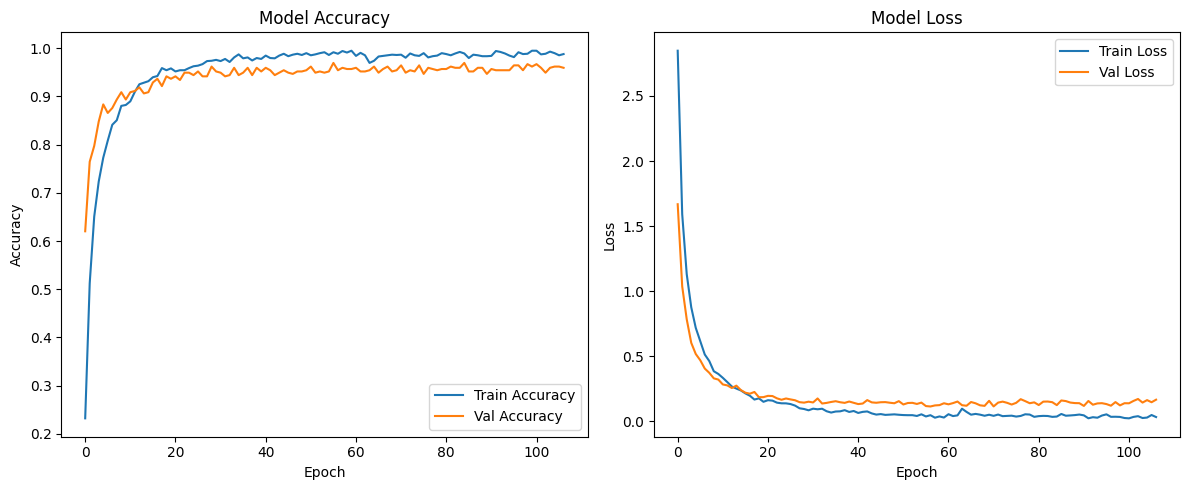

In [13]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history_initial)

In [14]:
for layer in base_model.layers[-20:]:  
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
early_stopping_fine_tunning = EarlyStopping(
    monitor='val_loss',    
    patience=100,            
    restore_best_weights=True  
)

In [16]:
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2500,
    initial_epoch=history_initial.epoch[-1],  
    callbacks=[early_stopping],
    verbose=1  
)

Epoch 107/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.4818 - loss: 3.7865 - val_accuracy: 0.9241 - val_loss: 0.1776
Epoch 108/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.4939 - loss: 3.5727 - val_accuracy: 0.8759 - val_loss: 0.3974
Epoch 109/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.4950 - loss: 3.5524 - val_accuracy: 0.8000 - val_loss: 0.7497
Epoch 110/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 375ms/step - accuracy: 0.5097 - loss: 3.2947 - val_accuracy: 0.7418 - val_loss: 1.1018
Epoch 111/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.5065 - loss: 2.9742 - val_accuracy: 0.6937 - val_loss: 1.3534
Epoch 112/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 376ms/step - accuracy: 0.5228 - loss: 2.8406 - val_accuracy: 0.6709 - val_loss: 1.5046
Epoch 113/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - accuracy: 0.5811 - loss: 2.6063 - val_accuracy: 0.6608 - val_loss: 1.5686
Epoch 114/2500
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - accuracy: 

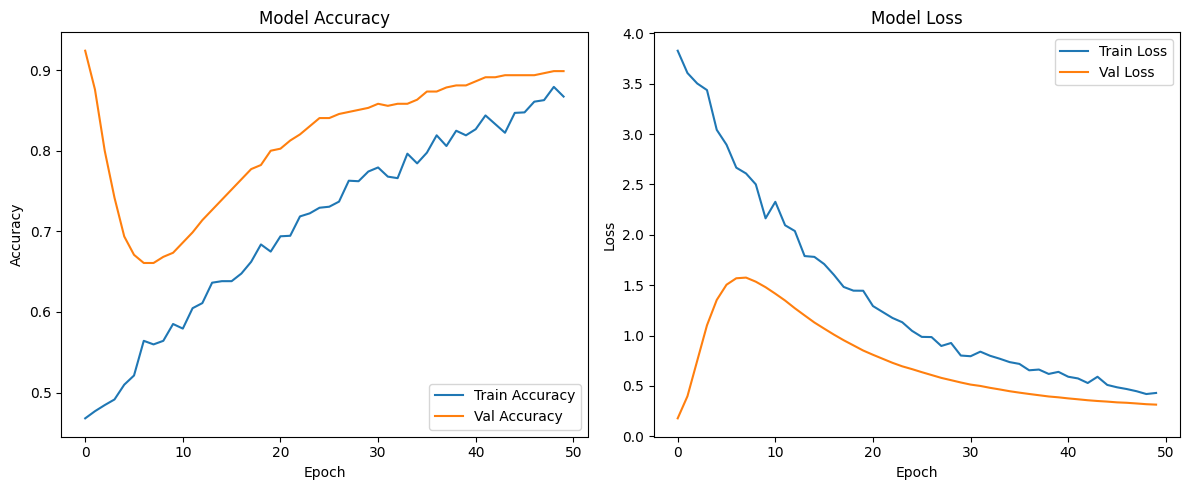

In [17]:
plot_training_history(history_fine_tune)

In [18]:
model.save('fine_tuned_model4.keras')

In [19]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.9515 - loss: 0.1480
Test Accuracy: 94.25%
Test Loss: 0.1488
